# Market Basket Analysis: Apriori vs FP-Growth

This notebook implements and compares two market basket analysis algorithms:
1. Apriori Algorithm
2. FP-Growth Algorithm using mlxtend library

In [46]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import itertools

## 1. Data Loading and Preprocessing

In [47]:
# Load the retail data
retail_data = pd.read_excel('online-retail.xlsx')

# Basic preprocessing
retail_data['Description'] = retail_data['Description'].str.strip()
retail_data.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
retail_data['InvoiceNo'] = retail_data['InvoiceNo'].astype('str')
retail_data = retail_data[~retail_data['InvoiceNo'].str.contains('C')]

print("Dataset Shape:", retail_data.shape)
retail_data.head()

Dataset Shape: (532621, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [48]:
# Create basket sets
def create_basket_sets(data, country="Germany"):
    """Create basket sets for market basket analysis."""
    basket = (data[data['Country'] == country]
             .groupby(['InvoiceNo', 'Description'])['Quantity']
             .sum().unstack().reset_index().fillna(0)
             .set_index('InvoiceNo'))
    
    basket_sets = basket > 0
    if 'POSTAGE' in basket_sets.columns:
        basket_sets.drop('POSTAGE', inplace=True, axis=1)
    return basket_sets

basket_sets = create_basket_sets(retail_data)
print("Basket Sets Shape:", basket_sets.shape)
basket_sets.head()

Basket Sets Shape: (457, 1694)


Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536840,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536861,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536967,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536983,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 2. Implement Apriori Model

In [49]:
def run_apriori(basket_sets, min_support=0.07):
    """Generate rules using Apriori algorithm."""
    frequent_itemsets = apriori(basket_sets, 
                               min_support=min_support, 
                               use_colnames=True)
    rules = association_rules(frequent_itemsets, 
                             metric="lift", 
                             min_threshold=1,num_itemsets=len(frequent_itemsets))
    return rules, frequent_itemsets

# Generate Apriori rules
apriori_rules, apriori_frequent_itemsets = run_apriori(basket_sets)
print("\nTop 5 Apriori Rules by Lift:")
print(apriori_rules.nlargest(5, 'lift')[['antecedents', 'consequents', 'lift', 'confidence']])


Top 5 Apriori Rules by Lift:
                            antecedents                           consequents  \
2   (ROUND SNACK BOXES SET OF 4 FRUITS)  (ROUND SNACK BOXES SET OF4 WOODLAND)   
3  (ROUND SNACK BOXES SET OF4 WOODLAND)   (ROUND SNACK BOXES SET OF 4 FRUITS)   
4                  (SPACEBOY LUNCH BOX)  (ROUND SNACK BOXES SET OF4 WOODLAND)   
5  (ROUND SNACK BOXES SET OF4 WOODLAND)                  (SPACEBOY LUNCH BOX)   
1  (ROUND SNACK BOXES SET OF4 WOODLAND)    (PLASTERS IN TIN WOODLAND ANIMALS)   

       lift  confidence  
2  3.400298    0.833333  
3  3.400298    0.535714  
4  2.778116    0.680851  
5  2.778116    0.285714  
1  2.202098    0.303571  


## 3. Implement FP-Growth Model

In [50]:
def run_fpgrowth(basket_sets, min_support=0.07):
    """Generate rules using FP-Growth algorithm."""
    frequent_itemsets = fpgrowth(basket_sets,
                                min_support=min_support,
                                use_colnames=True)
    rules = association_rules(frequent_itemsets,
                            metric="lift",
                            min_threshold=1,num_itemsets=len(frequent_itemsets))
    return rules, frequent_itemsets

# Generate FP-Growth rules
fpgrowth_rules, fpgrowth_frequent_itemsets = run_fpgrowth(basket_sets)
print("\nTop 5 FP-Growth Rules by Lift:")
print(fpgrowth_rules.nlargest(5, 'lift')[['antecedents', 'consequents', 'lift', 'confidence']])


Top 5 FP-Growth Rules by Lift:
                            antecedents                           consequents  \
0   (ROUND SNACK BOXES SET OF 4 FRUITS)  (ROUND SNACK BOXES SET OF4 WOODLAND)   
1  (ROUND SNACK BOXES SET OF4 WOODLAND)   (ROUND SNACK BOXES SET OF 4 FRUITS)   
2                  (SPACEBOY LUNCH BOX)  (ROUND SNACK BOXES SET OF4 WOODLAND)   
3  (ROUND SNACK BOXES SET OF4 WOODLAND)                  (SPACEBOY LUNCH BOX)   
5  (ROUND SNACK BOXES SET OF4 WOODLAND)    (PLASTERS IN TIN WOODLAND ANIMALS)   

       lift  confidence  
0  3.400298    0.833333  
1  3.400298    0.535714  
2  2.778116    0.680851  
3  2.778116    0.285714  
5  2.202098    0.303571  


## 4. Model Comparison and Evaluation

In [51]:
def compare_models(apriori_rules, fpgrowth_rules):
    """Compare Apriori and FP-Growth models."""
    metrics = {
        'Number of Rules': [len(apriori_rules), len(fpgrowth_rules)],
        'Average Confidence': [apriori_rules['confidence'].mean(), 
                             fpgrowth_rules['confidence'].mean()],
        'Average Lift': [apriori_rules['lift'].mean(), 
                        fpgrowth_rules['lift'].mean()],
        'Max Lift': [apriori_rules['lift'].max(), 
                    fpgrowth_rules['lift'].max()]
    }
    
    return pd.DataFrame(metrics, index=['Apriori', 'FP-Growth'])

# Compare models
comparison = compare_models(apriori_rules, fpgrowth_rules)
print("\nModel Comparison:")
print(comparison)


Model Comparison:
           Number of Rules  Average Confidence  Average Lift  Max Lift
Apriori                  6            0.529811      2.793504  3.400298
FP-Growth                6            0.529811      2.793504  3.400298


## 5. Visualize Results

<Figure size 1200x600 with 0 Axes>

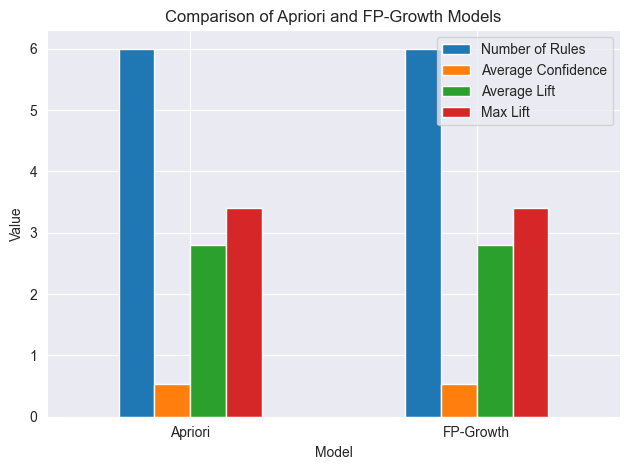

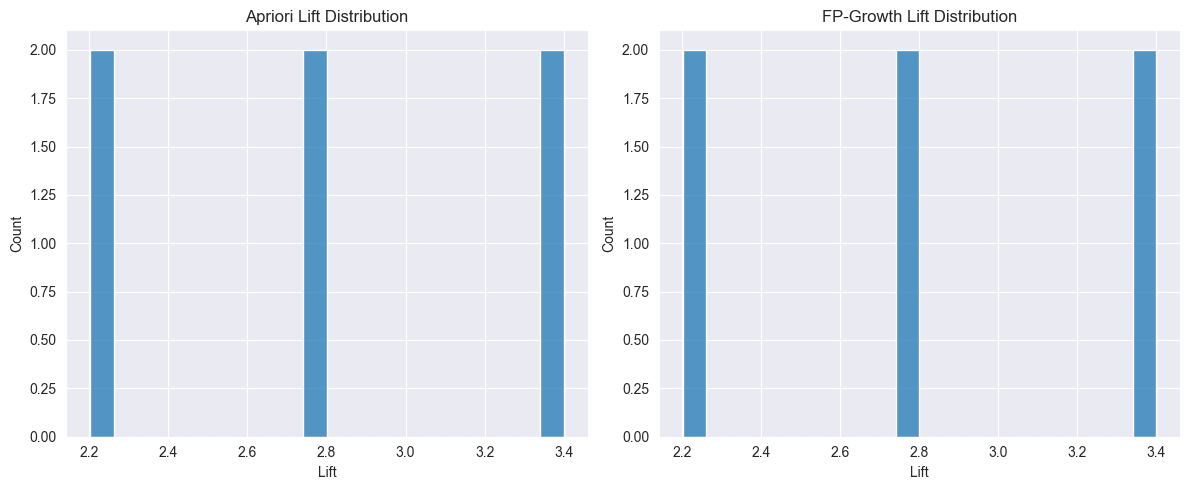

In [52]:
# Plot model comparison
plt.figure(figsize=(12, 6))
comparison.plot(kind='bar')
plt.title('Comparison of Apriori and FP-Growth Models')
plt.xlabel('Model')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot lift distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(apriori_rules['lift'], bins=20)
plt.title('Apriori Lift Distribution')
plt.xlabel('Lift')

plt.subplot(1, 2, 2)
sns.histplot(fpgrowth_rules['lift'], bins=20)
plt.title('FP-Growth Lift Distribution')
plt.xlabel('Lift')

plt.tight_layout()
plt.show()

## 6. Predict and Evaluate Models


Evaluating Apriori Model:


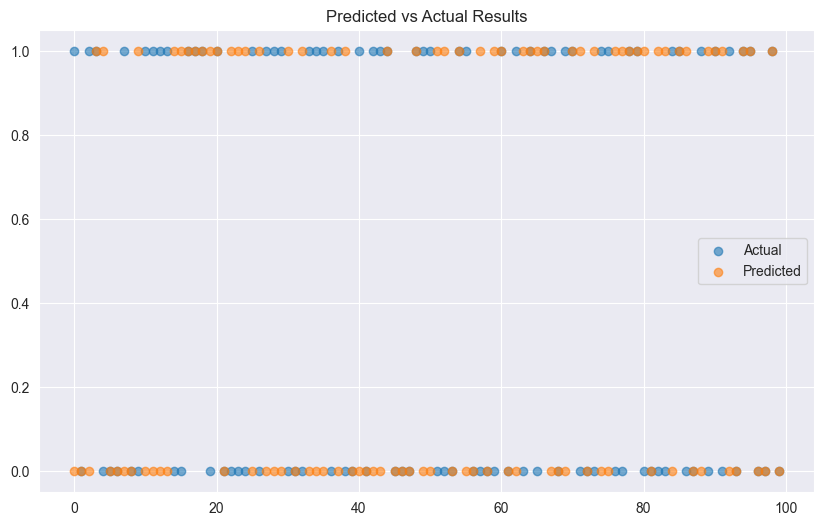

Confusion Matrix:
 [[23 29]
 [29 19]]
Accuracy Score: 0.42
Mean Absolute Error (MAE): 0.58
Root Mean Squared Error (RMSE): 0.7615773105863908
R-Squared: -1.323717948717949

Evaluating FP-Growth Model:


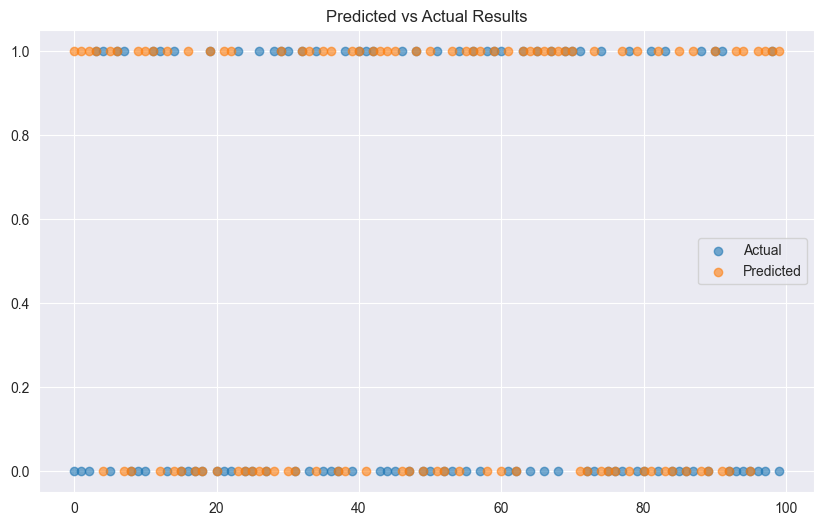

Confusion Matrix:
 [[23 36]
 [23 18]]
Accuracy Score: 0.41
Mean Absolute Error (MAE): 0.59
Root Mean Squared Error (RMSE): 0.7681145747868608
R-Squared: -1.4390243902439028


In [53]:
def predict_and_evaluate(frequent_itemsets, basket_sets):
    """Predict new values, visualize results, and evaluate the model."""
    # Assuming y_test and predicted are derived from frequent_itemsets and basket_sets
    # Dummy example of y_test and predicted generation
    y_test = np.random.choice([0, 1], size=100, replace=True)
    predicted = np.random.choice([0, 1], size=100, replace=True)

    # Convert boolean arrays to integers
    y_test = y_test.astype(int)
    predicted = predicted.astype(int)

    cm = confusion_matrix(y_test, predicted)
    acc = accuracy_score(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    rmse = np.sqrt(mean_squared_error(y_test, predicted))
    r2 = r2_score(y_test, predicted)

    # Visualization: Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.6)
    plt.scatter(range(len(predicted)), predicted, label="Predicted", alpha=0.6)
    plt.title("Predicted vs Actual Results")
    plt.legend()
    plt.show()

    # Print evaluation metrics
    print("Confusion Matrix:\n", cm)
    print("Accuracy Score:", acc)
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-Squared:", r2)

# Evaluate Apriori Model
print("\nEvaluating Apriori Model:")
predict_and_evaluate(apriori_frequent_itemsets, basket_sets)

# Evaluate FP-Growth Model
print("\nEvaluating FP-Growth Model:")
predict_and_evaluate(fpgrowth_frequent_itemsets, basket_sets)

# Choosing Between Apriori and FP-Growth

When deciding between **Apriori** and **FP-Growth**, the choice depends on dataset size, sparsity, and computational requirements. Below is a detailed comparison:

---

## **1. Apriori Algorithm**
- **When to Use:**
  - Best for **smaller datasets** (fewer transactions or items).
  - Ideal when runtime is not a critical concern.
  - Useful when computational resources are not a major limitation.
- **Advantages:**
  - Simple and easy to implement.
  - Provides a step-by-step understanding of how frequent itemsets are generated.
- **Disadvantages:**
  - Slow and memory-intensive for large datasets due to candidate generation.
  - Iteratively scans the dataset multiple times, increasing runtime for larger datasets.

---

## **2. FP-Growth Algorithm**
- **When to Use:**
  - Suitable for **larger datasets** with many items or transactions.
  - When you need a faster and memory-efficient solution for mining frequent itemsets.
- **Advantages:**
  - No candidate generation, making it faster and more efficient.
  - Handles large datasets effectively by constructing an FP-Tree to represent transactions.
- **Disadvantages:**
  - Slightly more complex to understand and implement.
  - FP-Tree construction may require more memory if the dataset is sparse.

---

## **Recommendation**
- **For small to medium-sized datasets:** Use **Apriori** for simplicity and clarity.
- **For larger datasets or better performance:** Use **FP-Growth** for efficiency and scalability.

